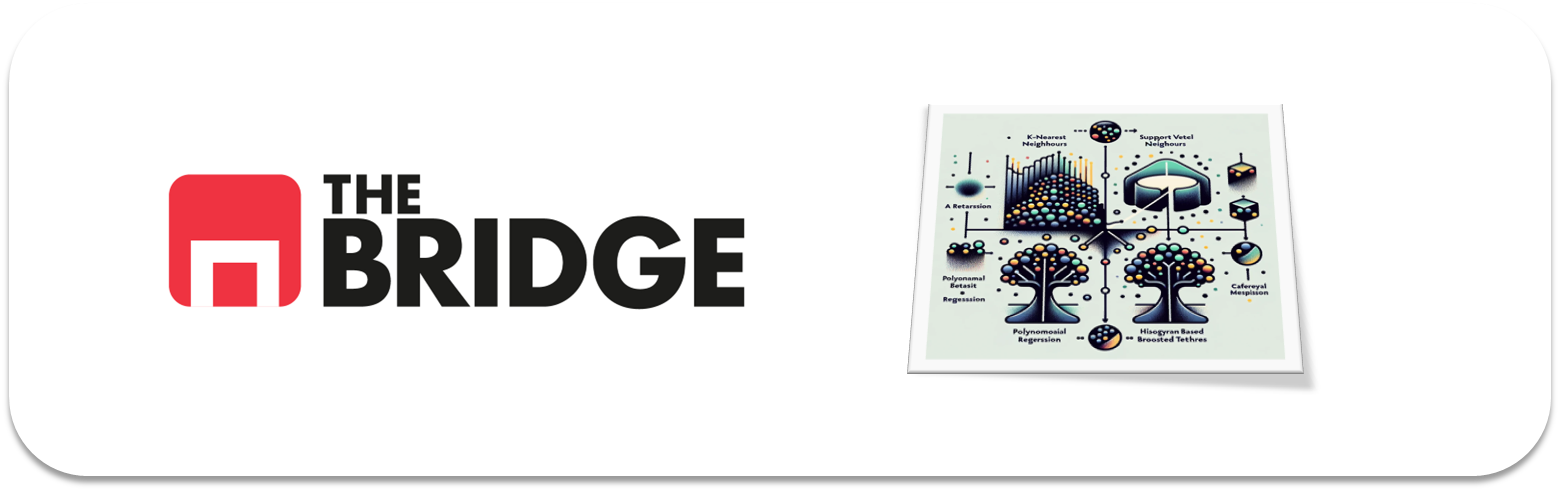

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost
from sklearn.metrics import classification_report, make_scorer, recall_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import matplotlib.pyplot as plt

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [2]:
dataset = pd.read_csv("./data/wines_dataset.csv", sep="|")
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red


<Axes: xlabel='quality'>

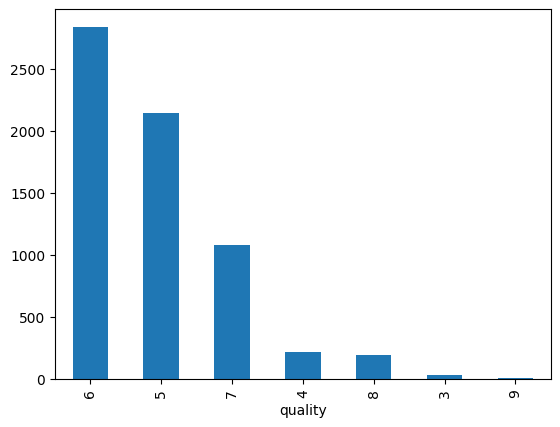

In [3]:
dataset.quality.value_counts().plot(kind='bar')

In [4]:
#Parece que la calidad del vino va de 3 a 9. Dado que no hay datos en otros intervalos y que se puede considerar como variable categorica, vamos a restar 3 a la calidad para que vaya de 0 a 6.
dataset["quality"] = dataset["quality"] - 3

In [5]:
dataset['quality'] = dataset['quality'].astype('category')

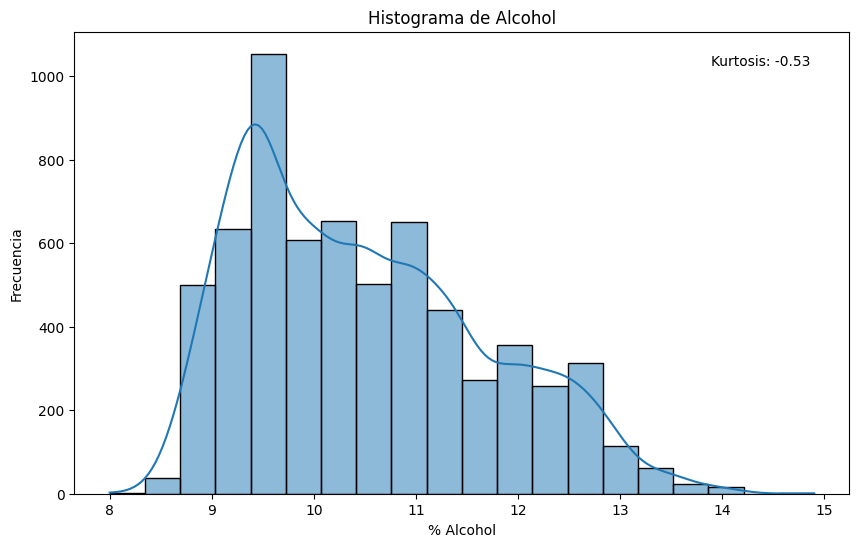

In [6]:
from scipy.stats import kurtosis

#Calculamos la kurtosis de la variable 'alcohol' para ver si se puede considerar como una distribución normal
kurt_value = kurtosis(dataset['alcohol'])

plt.figure(figsize=(10, 6))
sns.histplot(dataset['alcohol'], bins=20, kde=True)
plt.title('Histograma de Alcohol')
plt.xlabel('% Alcohol')
plt.ylabel('Frecuencia')

#Incluimos la kurtosis en el grafico para verlo mas facilmente
plt.text(0.95, 0.95, f'Kurtosis: {kurt_value:.2f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

plt.show()

Parece que sigue una distribución normal con un valor de kurtosis aceptable. No haría falta transformarla

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

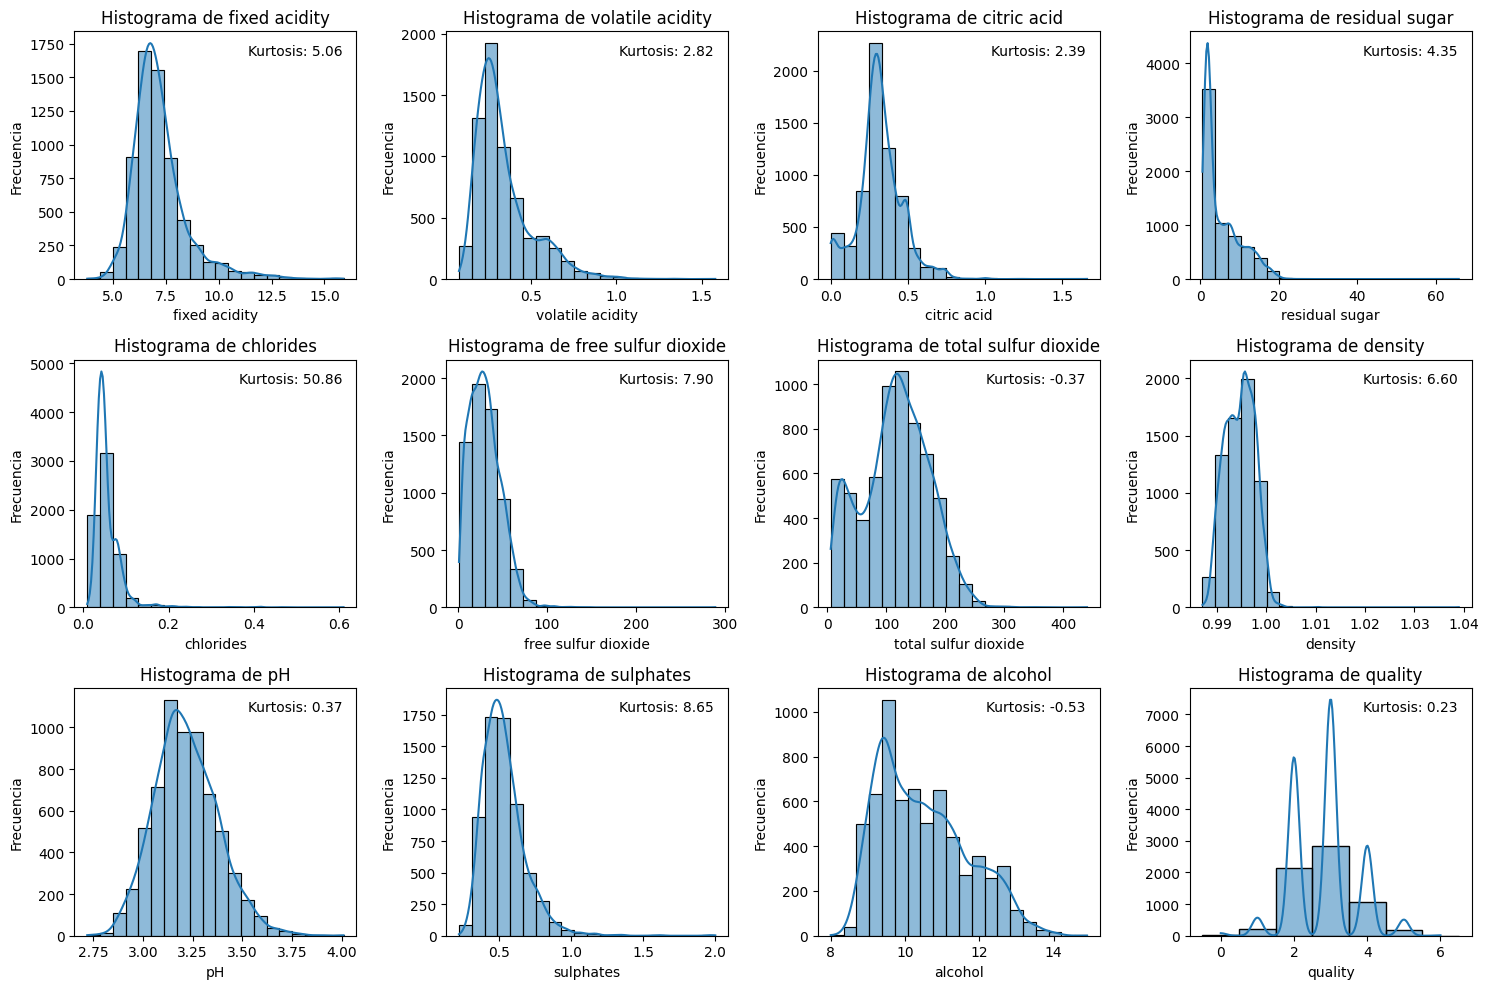

In [7]:
from scipy.stats import kurtosis

num_columns = 4
num_rows = int(np.ceil((len(dataset.columns) - 1) / num_columns))

# Crear la figura y los subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(dataset.columns):
    if col != 'class':  
        sns.histplot(dataset[col], bins=20, kde=True, ax=axes[i])
        axes[i].set_title(f'Histograma de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
       
        kurt_value = kurtosis(dataset[col])
        
        axes[i].text(0.95, 0.95, f'Kurtosis: {kurt_value:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[i].transAxes)

plt.tight_layout()
plt.show()

Parece que algunas columnas tienen outliers, pues tienen un valor de kurtosis superior a 2. Sin embargo, dado que es un problema de clasificación, estos outliers pueden estar relacionados con distintas clases.  
Vamos a mantenerlos sin buscar distribuciones más normalizadas, pues puede ayudar a algoritmos como randomforest.   
Dado que la distribucion de calidades está muy mal distribuida, se va a probar a hacer algoritmos sin optimizar sin usar SMOTE y después usando SMOTE

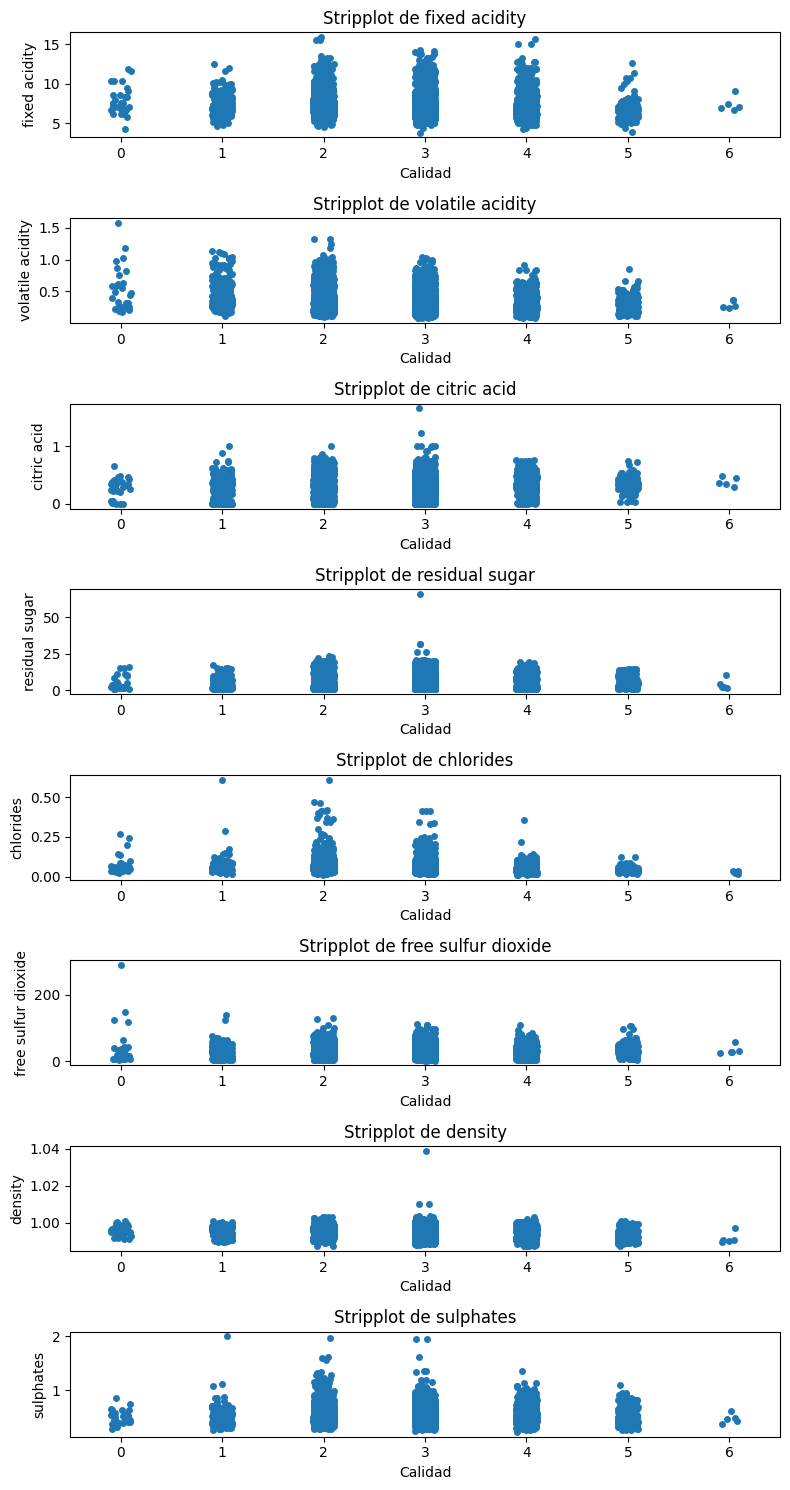

In [8]:
# Calcular las columnas numéricas con alta kurtosis (superior a 2)
numerical_columns = dataset.select_dtypes(include=[np.number]).columns
kurtosis_values = dataset[numerical_columns].kurtosis()
high_kurtosis_columns = kurtosis_values[kurtosis_values > 2].index

# Representar el stripplot para las variables filtradas
plt.figure(figsize=(8, 15))
for i, col in enumerate(high_kurtosis_columns, 1):
    plt.subplot(len(high_kurtosis_columns), 1, i)
    sns.stripplot(x='quality', y=col, data=dataset, jitter=True)
    plt.title(f'Stripplot de {col}')
    plt.xlabel('Calidad')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [9]:
X = dataset.drop(columns=['quality'])
X = pd.get_dummies(X, columns=['class'])
y = dataset['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Definimos como score el recall medio como dice el enunciado
recall_scorer = make_scorer(recall_score, average='macro')

#Calculamos el recall medio para cada modelo usando CV con 3 folds

#KNN con k=3
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3_scores = cross_val_score(knn_3, X_train, y_train, cv=3, scoring=recall_scorer)
print(f"KNN (k=3) Recall Medio: {knn_3_scores.mean():.4f}")

#KNN con k=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5_scores = cross_val_score(knn_5, X_train, y_train, cv=3, scoring=recall_scorer)
print(f"KNN (k=5) Recall Medio: {knn_5_scores.mean():.4f}")

#Random Forest
rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=3, scoring=recall_scorer)
print(f"Random Forest Recall Medio: {rf_scores.mean():.4f}")

#XGBoost
xgb_model = xgboost.XGBClassifier(random_state=42)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=3, scoring=recall_scorer)
print(f"XGB Recall Medio: {xgb_scores.mean():.4f}")

KNN (k=3) Recall Medio: 0.2483
KNN (k=5) Recall Medio: 0.2194
Random Forest Recall Medio: 0.3372
XGB Recall Medio: 0.3406


In [10]:
#Calculamos los classification reports para cada modelo

#KNN con k=3
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train, y_train)
y_pred_knn_3 = knn_3.predict(X_test)
print("Classification Report para KNN (k=3):")
print(classification_report(y_test, y_pred_knn_3))

#KNN con k=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)
y_pred_knn_5 = knn_5.predict(X_test)
print("Classification Report para KNN (k=5):")
print(classification_report(y_test, y_pred_knn_5))

#Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Classification Report para Random Forest:")
print(classification_report(y_test, y_pred_rf))

#XGBoost
xgb_model = xgboost.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("Classification Report para XGBoost:")
print(classification_report(y_test, y_pred_xgb))


Classification Report para KNN (k=3):
              precision    recall  f1-score   support

           0       0.11      0.17      0.13         6
           1       0.08      0.12      0.09        43
           2       0.46      0.48      0.47       428
           3       0.51      0.53      0.52       567
           4       0.37      0.30      0.33       216
           5       0.18      0.08      0.11        39
           6       0.00      0.00      0.00         1

    accuracy                           0.45      1300
   macro avg       0.24      0.24      0.24      1300
weighted avg       0.44      0.45      0.44      1300

Classification Report para KNN (k=5):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.11      0.07      0.09        43
           2       0.47      0.53      0.50       428
           3       0.49      0.55      0.52       567
           4       0.34      0.24      0.28       216
  

c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Classification Report para Random Forest:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.71      0.12      0.20        43
           2       0.74      0.71      0.72       428
           3       0.64      0.79      0.71       567
           4       0.68      0.51      0.58       216
           5       0.93      0.33      0.49        39
           6       0.00      0.00      0.00         1

    accuracy                           0.68      1300
   macro avg       0.53      0.35      0.39      1300
weighted avg       0.68      0.68      0.66      1300



c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Classification Report para XGBoost:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.14      0.22        43
           2       0.69      0.71      0.70       428
           3       0.64      0.74      0.69       567
           4       0.65      0.54      0.59       216
           5       0.71      0.31      0.43        39
           6       0.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.46      0.35      0.37      1300
weighted avg       0.65      0.66      0.65      1300



c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Se obtienen valores generalmente bajos. Eso es debido a que hay pocos datos de las clases 0 y 6.

Repetimos ahora usando SMOTE

In [11]:
smote = SMOTE(k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(y_train_resampled.value_counts())

quality
0    2269
1    2269
2    2269
3    2269
4    2269
5    2269
6    2269
Name: count, dtype: int64


In [12]:
#Repetimos pero con los nuevos datos

recall_scorer = make_scorer(recall_score, average='macro')

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3_scores = cross_val_score(knn_3, X_train_resampled, y_train_resampled, cv=5, scoring=recall_scorer)
print(f"KNN (k=3) Recall Medio: {knn_3_scores.mean():.4f}")

knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5_scores = cross_val_score(knn_5, X_train_resampled, y_train_resampled, cv=5, scoring=recall_scorer)
print(f"KNN (k=5) Recall Medio: {knn_5_scores.mean():.4f}")

rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring=recall_scorer)
print(f"Random Forest Recall Medio: {rf_scores.mean():.4f}")

xgb_model = xgboost.XGBClassifier(random_state=42)
xgb_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=5, scoring=recall_scorer)
print(f"XGB Recall Medio: {xgb_scores.mean():.4f}")




KNN (k=3) Recall Medio: 0.8196
KNN (k=5) Recall Medio: 0.7846
Random Forest Recall Medio: 0.8878
XGB Recall Medio: 0.8779


In [13]:
from sklearn.metrics import classification_report

# Ajustar y predecir con KNN (k=3)
knn_3.fit(X_train_resampled, y_train_resampled)
y_pred_knn_3 = knn_3.predict(X_test)
print("Classification Report for KNN (k=3):")
print(classification_report(y_test, y_pred_knn_3))

# Ajustar y predecir con KNN (k=5)
knn_5.fit(X_train_resampled, y_train_resampled)
y_pred_knn_5 = knn_5.predict(X_test)
print("Classification Report for KNN (k=5):")
print(classification_report(y_test, y_pred_knn_5))

# Ajustar y predecir con Random Forest
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Ajustar y predecir con XGB
xgb_model = xgboost.XGBClassifier(random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))



Classification Report for KNN (k=3):
              precision    recall  f1-score   support

           0       0.01      0.17      0.03         6
           1       0.08      0.23      0.12        43
           2       0.56      0.47      0.51       428
           3       0.59      0.40      0.47       567
           4       0.40      0.47      0.43       216
           5       0.18      0.44      0.26        39
           6       0.00      0.00      0.00         1

    accuracy                           0.43      1300
   macro avg       0.26      0.31      0.26      1300
weighted avg       0.51      0.43      0.46      1300

Classification Report for KNN (k=5):
              precision    recall  f1-score   support

           0       0.01      0.17      0.02         6
           1       0.09      0.33      0.14        43
           2       0.53      0.43      0.47       428
           3       0.57      0.32      0.41       567
           4       0.38      0.46      0.41       216
    

c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.27      0.28      0.27        43
           2       0.70      0.67      0.69       428
           3       0.66      0.67      0.67       567
           4       0.59      0.62      0.61       216
           5       0.35      0.36      0.35        39
           6       0.00      0.00      0.00         1

    accuracy                           0.64      1300
   macro avg       0.37      0.37      0.37      1300
weighted avg       0.64      0.64      0.64      1300



c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sergi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

El recall medio sube, pero cuando pasamos al set de test los resultados son bastante malos en cuanto a   
recall y precisón. Sigue pasando que las clases 0 y 6 no se predicen bien

Usando SMOTE y sin usarlo los resultados son malos para las clases menos minoritarias. Se va a cambiar el enfoque, dividiendo las categorias en 3 calidades: Baja, Media y Buena, pero usando numeros (0, 1 y 2) para que XGBoost pueda aceptarlas como valores

In [14]:
#Cargamos de nuevo el dataset y creamos las nuevas categorias
dataset = pd.read_csv("./data/wines_dataset.csv", sep="|")

In [15]:
#Creamos las tres categorías para la variable "quality". Por debajo de 5, será "Baja", 
#entre 5 y 6 será "Media" y por encima de 6 será "Alta"
#Sin embargo, dado que xgboost no acepta variables categóricas, vamos a convertir estas categorías en valores numéricos
bins = [0, 5, 6, 10]
labels = [0, 1, 2]
dataset['quality_c'] = pd.cut(dataset['quality'], bins=bins, labels=labels, include_lowest=True)

<Axes: xlabel='quality_c'>

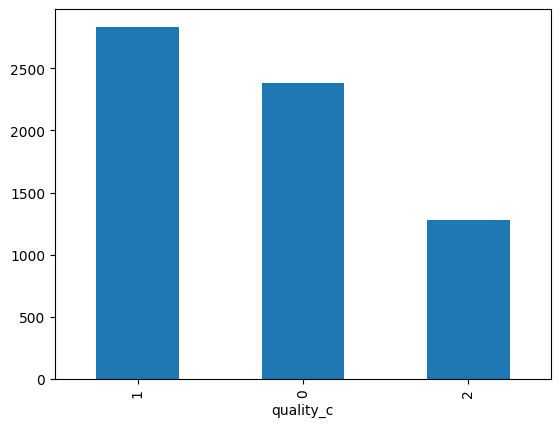

In [16]:
dataset['quality_c'].value_counts().plot(kind='bar')

In [17]:
# Separar características y_train target
X = dataset.drop(columns=['quality', "quality_c"])
X = pd.get_dummies(X, columns=['class'])
y = dataset['quality_c']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definir el scorer para recall medio
recall_scorer = make_scorer(recall_score, average='macro')

# Modelo baseline KNN con k=3
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3_scores = cross_val_score(knn_3, X_train, y_train, cv=3, scoring=recall_scorer)
print(f"KNN (k=3) Recall Medio: {knn_3_scores.mean():.4f}")

# Modelo baseline KNN con k=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5_scores = cross_val_score(knn_5, X_train, y_train, cv=3, scoring=recall_scorer)
print(f"KNN (k=5) Recall Medio: {knn_5_scores.mean():.4f}")

# Modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=3, scoring=recall_scorer)
print(f"Random Forest Recall Medio: {rf_scores.mean():.4f}")

# Modelo XGB
xgb_model = xgboost.XGBClassifier(random_state=42)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=3, scoring=recall_scorer)
print(f"XGB Recall Medio: {xgb_scores.mean():.4f}")

KNN (k=3) Recall Medio: 0.4891
KNN (k=5) Recall Medio: 0.4671
Random Forest Recall Medio: 0.6644
XGB Recall Medio: 0.6512


In [18]:
# Modelo baseline KNN con k=3
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train, y_train)
y_pred_knn_3 = knn_3.predict(X_test)
print("Classification Report for KNN (k=3):")
print(classification_report(y_test, y_pred_knn_3))

# Modelo baseline KNN con k=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)
y_pred_knn_5 = knn_5.predict(X_test)
print("Classification Report for KNN (k=5):")
print(classification_report(y_test, y_pred_knn_5))

# Modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Modelo XGBoost
xgb_model = xgboost.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

Classification Report for KNN (k=3):
              precision    recall  f1-score   support

           0       0.52      0.58      0.55       477
           1       0.55      0.53      0.54       567
           2       0.47      0.40      0.43       256

    accuracy                           0.52      1300
   macro avg       0.51      0.51      0.51      1300
weighted avg       0.52      0.52      0.52      1300

Classification Report for KNN (k=5):
              precision    recall  f1-score   support

           0       0.53      0.58      0.56       477
           1       0.53      0.54      0.54       567
           2       0.47      0.36      0.41       256

    accuracy                           0.52      1300
   macro avg       0.51      0.50      0.50      1300
weighted avg       0.52      0.52      0.52      1300

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       477
           1  

Se obtienen resultados con mayor precision que en el caso anterior. RandomForest ha sido ligeramente mejor que XGBoost, asi que   
vamos a optimizarlo

In [19]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Crear el modelo de RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring=recall_scorer)

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)



Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [20]:
# Evaluar el mejor modelo en el conjunto de prueba
y_pred_best_rf = best_rf.predict(X_test)
print("Classification Report for Optimized Random Forest:")
print(classification_report(y_test, y_pred_best_rf))

Classification Report for Optimized Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       477
           1       0.65      0.76      0.70       567
           2       0.77      0.59      0.67       256

    accuracy                           0.71      1300
   macro avg       0.73      0.69      0.71      1300
weighted avg       0.72      0.71      0.71      1300



### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

En este caso, vamos a empezar de cero cargando de nuevo el dataset. Después se van a estandarizar las columnas numéricas, pues en caso de una regresión puede mejorar el modelo.   
Después, se va a probar a ver si los modelos sin optimizar mejoran si se eliminan las columnas numericas con menor correlación.   
Para las categóricas, se van a "encodear" usando pandas

In [21]:
dataset = pd.read_csv("./data/wines_dataset.csv", sep="|")

bins = [0, 5, 6, 10]
labels = ["Baja","Media","Alta"]
dataset['quality_c'] = pd.cut(dataset['quality'], bins=bins, labels=labels, include_lowest=True)
dataset.drop("quality", axis=1, inplace=True)


In [22]:
#Calculamos la correlación de las variables numéricas con la variable target "alcohol"
numericas = dataset.select_dtypes(include=[np.number]).columns
correlation_matrix = dataset[numericas].corr()
correlacion_con_target = correlation_matrix["alcohol"].sort_values(ascending=False)

print(correlacion_con_target)

alcohol                 1.000000
pH                      0.121248
sulphates              -0.003029
citric acid            -0.010493
volatile acidity       -0.037640
fixed acidity          -0.095452
free sulfur dioxide    -0.179838
chlorides              -0.256916
total sulfur dioxide   -0.265740
residual sugar         -0.359415
density                -0.686745
Name: alcohol, dtype: float64


Parece que hay poca correlacion entre las variables y el grado de alcohol

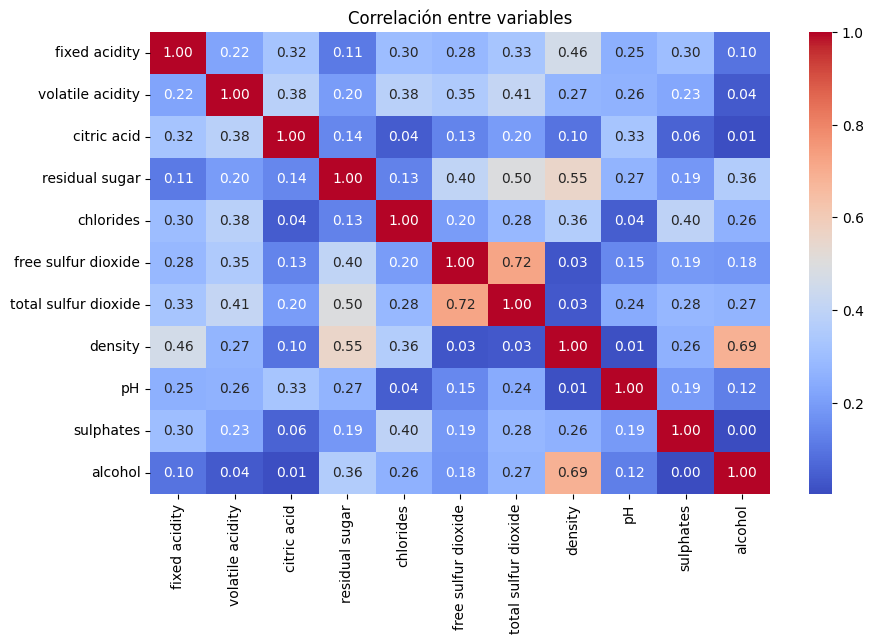

In [23]:
#Para usarlo después, vamos a ver las correlaciones entre las variables numéricas

plt.figure(figsize=(10, 6))
sns.heatmap(dataset[numerical_columns].corr().abs(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables")
plt.show()

Hay correlacion entre las variables "total sulfur dioxide" y "free sulfur dioxide". Tiene sentido, al estar relacionadas con el mismo compuesto quimico.   
Vamos a mantenerlas porque la correlacion es alta pero no es excesiva

In [24]:
scaler = StandardScaler()

X = dataset.drop("alcohol", axis = 1)
y = dataset["alcohol"]

numericas = X.select_dtypes(include=[np.number]).columns

X = pd.get_dummies(X, columns=['class', 'quality_c'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[numericas] = scaler.fit_transform(X_train[numericas])
X_test[numericas] = scaler.transform(X_test[numericas])

In [25]:
#Ahora vamos a generar tres modelos sin optimizar hiperparámetros

# Modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"R2 para Regresión Lineal: {lr.score(X_test, y_test):.4f}")
print(f"MAE para Regresión Lineal: {mean_absolute_error(y_test, y_pred_lr):.4f}")
print(f"RMSE para Regresión Lineal: {root_mean_squared_error(y_test, y_pred_lr):.4f}")

# Modelo de Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"R2 para Random Forest: {rf.score(X_test, y_test):.4f}")
print(f"MAE para Random Forest: {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"RMSE para Random Forest: {root_mean_squared_error(y_test, y_pred_rf):.4f}")

# Modelo de XGBoost
xgb_model = xgboost.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(f"R2 para XGBoost: {xgb_model.score(X_test, y_test):.4f}")
print(f"MAE para XGBoost: {mean_absolute_error(y_test, y_pred_xgb):.4f}")
print(f"RMSE para XGBoost: {root_mean_squared_error(y_test, y_pred_xgb):.4f}")


R2 para Regresión Lineal: 0.8424
MAE para Regresión Lineal: 0.3543
RMSE para Regresión Lineal: 0.4713
R2 para Random Forest: 0.8838
MAE para Random Forest: 0.2642
RMSE para Random Forest: 0.4047
R2 para XGBoost: 0.8952
MAE para XGBoost: 0.2562
RMSE para XGBoost: 0.3844


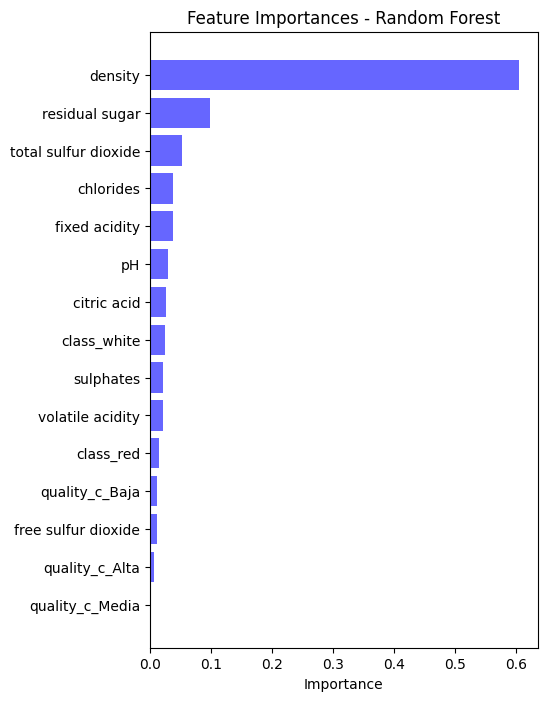

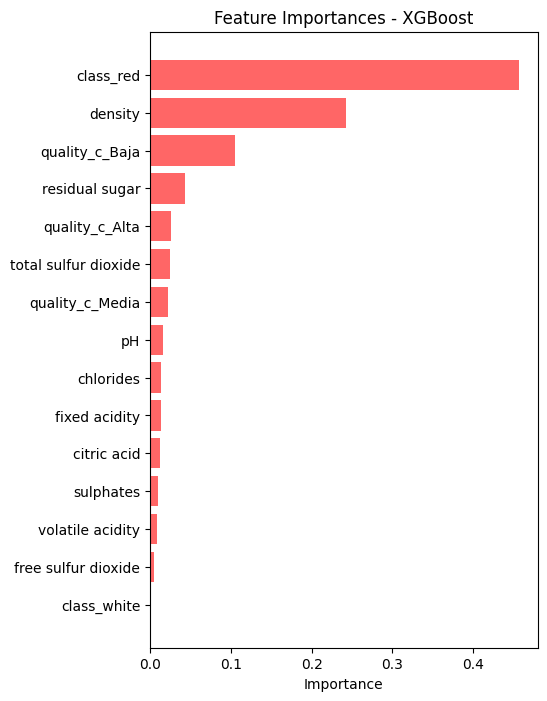

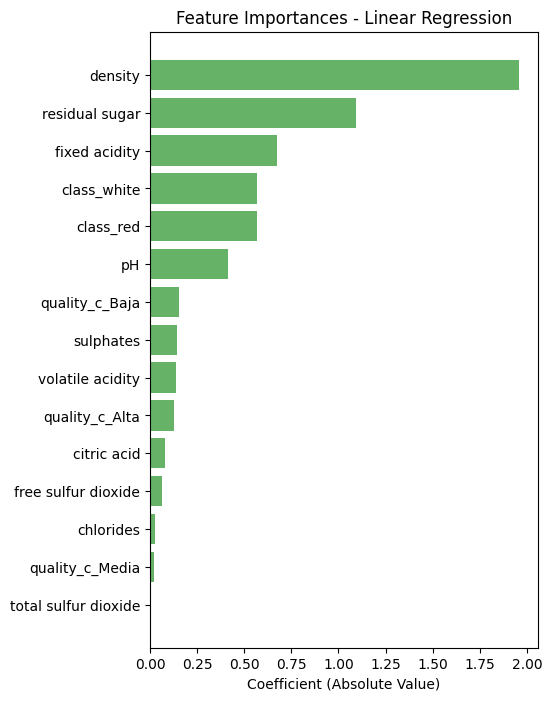

In [26]:
#Vamos a ver las importancias de las características para cada modelo
importances_rf = rf.feature_importances_
importances_xgb = xgb_model.feature_importances_
coefficients_lr = np.abs(lr.coef_)

#Creamos un dataframe para ordenarlas por modelo
feature_names = X_train.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest Importance': importances_rf,
    'XGBoost Importance': importances_xgb
})

#Orddenamos las columnas por importancia
importances_df_rf = importances_df.sort_values(by='Random Forest Importance', ascending=False)
importances_df_xgb = importances_df.sort_values(by='XGBoost Importance', ascending=False)
importances_df_lr = pd.DataFrame({'Feature': feature_names,'Linear Regression Coefficients': coefficients_lr}).sort_values(by='Linear Regression Coefficients', ascending=False)

#Representamos las importancias de las características para cada modelo
plt.figure(figsize=(5,8))
plt.barh(importances_df_rf['Feature'], importances_df_rf['Random Forest Importance'], color='b', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(5,8))
plt.barh(importances_df_xgb['Feature'], importances_df_xgb['XGBoost Importance'], color='r', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(5,8))
plt.barh(importances_df_lr['Feature'], importances_df_lr['Linear Regression Coefficients'], color='g', alpha=0.6)
plt.xlabel('Coefficient (Absolute Value)')
plt.title('Feature Importances - Linear Regression')
plt.gca().invert_yaxis()
plt.show()

RnadomForest y XGBoost dan importancias mas similares entre si que LinearRegression. Como era de esperar, la variable con mayor correlacion con el target (density)   
es la más importante

Como XGBoost ha sido el mejor modelo, vamos a centrarnos en él. Primero, vamos a probar si eliminando algunas columnas poco importantes el modelo mejora

In [27]:
X_train_2 = X_train.drop(columns=['class_white', 'free sulfur dioxide', "volatile acidity"])
X_test_2 = X_test.drop(columns=['class_white', 'free sulfur dioxide', "volatile acidity"])

In [28]:
xgb_model = xgboost.XGBRegressor(random_state=42)
xgb_model.fit(X_train_2, y_train)
y_pred_xgb = xgb_model.predict(X_test_2)
print(f"R2 para XGBoost: {xgb_model.score(X_test_2, y_test):.4f}")
print(f"MAE para XGBoost: {mean_absolute_error(y_test, y_pred_xgb):.4f}")
print(f"RMSE para XGBoost: {root_mean_squared_error(y_test, y_pred_xgb):.4f}")

R2 para XGBoost: 0.8978
MAE para XGBoost: 0.2554
RMSE para XGBoost: 0.3796


El modelo ha mejorado ligeramente. Seguimos adelante con estos para la optimización final

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

#Usamos de nuevo BayesSearchCV para optimizar los hiperparámetros de XGBoost

param_space = {
    "n_estimators": Integer(50, 500),
    "max_depth": Integer(3, 15),
    "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "subsample": Real(0.6, 1.0),
    "colsample_bytree": Real(0.6, 1.0),
    "gamma": Real(0, 5),
    "reg_alpha": Real(0, 10),
    "reg_lambda": Real(0, 10)
}

xgb_model = xgboost.XGBRegressor(random_state=42, tree_method="hist", device="cuda")

bayes_search = BayesSearchCV(estimator=xgb_model, search_spaces=param_space, n_iter=150, cv=3, n_jobs=-1, scoring="neg_mean_absolute_error", random_state=42)

bayes_search.fit(X_train_2, y_train)

best_xgb = bayes_search.best_estimator_


y_pred_best_xgb = best_xgb.predict(X_test_2)


In [30]:
print("R2 para XGBoost Optimizado:", best_xgb.score(X_test_2, y_test))
print("MAE para XGBoost Optimizado:", mean_absolute_error(y_test, y_pred_best_xgb))
print("RMSE para XGBoost Optimizado:", root_mean_squared_error(y_test, y_pred_best_xgb))


R2 para XGBoost Optimizado: 0.9086257897524849
MAE para XGBoost Optimizado: 0.2231104062887339
RMSE para XGBoost Optimizado: 0.35884971139454985
